In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

import sys


annualization_factor = 12 

# Q1

#### Q1

### Scenario 1: TIPs has no correlation to either rasset.
- Given that TIPs offered high yield and inflation protection, they offer significant diversification benefits which is useful in a MV optimization. Since the asset would reduce the overall portfolio risk without including any correlated risks, it is likely that it would be given a higher weight in the portfolio especially since it offers a higher expected mean return of 4% (compared to 0.14% on average in the case)
- The addition of TIPs will thus potentially improve the sharpe ratio of the portfolio.


### Scenario 2: TIPs has 100% correlation to IEF
- This means that TIPS will not offer any diversification benefit and TIPS and IEF would have the same risk profile. In a MV framework, this would like cause TIPS to be entirely excluded.


TIPS is unlikely to have 0% correlation to every other asset in the portfolio since it inherits characteristics of a bond and fixed income instrument. In fact, this means that they will be sensitive to interest rates and monetary policies which will thus exhibit some level of correlation with IEF and even equities. 

#### Q2

The alpha intercept term represents the non-factor component that cannot be explained by the factors used in the model. It can be useful in these cases: 

- Alpha capturing hedge funds would want to determine whether an asset has excess returns that are not explained by the systematic factors in the model and thus this will be usually included. For instance, the hedge fund would want to highlight its superior management skills. Alternatively, the Fama French Model and CAPM may want to highlight abnormal returns which could indicate mispricings and inefficiencies in the market.
- When an asset is benchmarked to its factors, the intercept can reveal whether the asset ouperformed or underperformed.
- The intercept also helps to adjust for the mean difference in residuals to ensure a better fit of the data for the factors, as reflected in their betas.

However, when should one exclude it? 
- When replicating or tracking an index through the factor exposures, the intercept may be excluded as these alpha returns cannot be captured by the index. In fact, the dependent variable should be assumed to be fully explained by the factors in the model, thus the intercept should be 0.
- As for hedge funds, if they are looking to hedge solely based on the risk factors, they can choose to exclude the intercept and focus on them. 

# Q2

In [8]:
df = pd.read_excel("./midterm_1_data.xlsx", sheet_name = 'stocks excess returns')
df = df.set_index('date')
df.head()

,AAPL,AMZN,BRK-B,GOOGL,JNJ,JPM,LLY,META,MSFT,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,
2012-06-30,0.010943,0.072609,0.050116,-0.001270,0.082263,0.077918,0.047953,0.050766,0.048052,0.111916,0.060768,0.052919,0.073267,0.088352
2012-07-31,0.045822,0.021677,0.018121,0.091196,0.024570,0.015958,0.026101,-0.301929,-0.036613,-0.020260,-0.123682,-0.126667,0.044002,0.014958
2012-08-31,0.093695,0.063985,-0.006075,0.082161,-0.017188,0.031486,0.031399,-0.168306,0.052556,0.036008,0.039935,0.062649,-0.004849,0.011533
2012-09-30,0.002878,0.024450,0.045849,0.101397,0.022030,0.090012,0.055749,0.199417,-0.034312,-0.049099,0.026730,0.024657,0.047099,0.047619
2012-10-31,-0.107527,-0.084192,-0.020903,-0.098271,0.027789,0.037321,0.025805,-0.025320,-0.040922,-0.101877,-0.039204,0.010720,0.033436,-0.002989


#### Q1

In [10]:
is_data = df.loc[:'2018']
os_data = df.loc['2019':]
# is_data.tail()
# os_data.head()

In [11]:
def portfolio_metrics_basic(returns: pd.DataFrame) -> pd.DataFrame: 
    '''
    Returns Annualized ER, Vol, SR, 
    '''
    
    returns_df = pd.DataFrame(index = returns.columns) 
    mu = returns.mean() * annualization_factor
    vol = returns.std() * np.sqrt(annualization_factor)
    sr = mu / vol

    
    returns_df['Annnualized Return'] = mu.values 
    returns_df['Annnualized Vol'] = vol.values 
    returns_df['Annnualized SR'] = sr.values
    
    return returns_df

def tangency_weights(returns,dropna=True,scale_cov=1, name = 'Tangency'):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()
    tangency_weights_df = pd.DataFrame(weights, index=returns.columns, columns=[f'{name} Weights'])

    return tangency_weights_df

def portfolio_returns_calc(data, weights_df): 
    return pd.DataFrame(data @ (weights_df.values)) 

tangency_weights_df = tangency_weights(is_data)
portfolio_tangency = portfolio_returns_calc(is_data, tangency_weights_df)
portfolio_tangency.columns = ['tangency_weights']
tangency_weights_df

,Tangency Weights
AAPL,-0.127836
AMZN,-0.040576
BRK-B,0.131333
GOOGL,0.025968
JNJ,0.130408
JPM,-0.013929
LLY,0.352670
META,0.030541
MSFT,0.137917
NVDA,0.163501


In [12]:
regularized_weights_df = tangency_weights(is_data, scale_cov=.5, name = 'Regularized')
portfolio_reg = portfolio_returns_calc(is_data, regularized_weights_df)
portfolio_reg.columns = ['reg_weights']
regularized_weights_df

,Regularized Weights
AAPL,-0.014706
AMZN,0.036310
BRK-B,0.109162
GOOGL,0.050545
JNJ,0.099190
JPM,0.053691
LLY,0.214949
META,0.034896
MSFT,0.089970
NVDA,0.071696


#### Q2

In [14]:
is_portfolios = pd.concat([
    portfolio_tangency, 
    portfolio_reg
], axis=1)
is_portfolios.columns = [_ for _ in is_portfolios.columns]
portfolio_metrics_basic(is_portfolios)

,Annnualized Return,Annnualized Vol,Annnualized SR
tangency_weights,0.348256,0.134053,2.597896
reg_weights,0.276599,0.114184,2.422392


#### Q3

In [16]:
os_portfolio_tangency = portfolio_returns_calc(os_data, tangency_weights_df)
os_portfolio_tangency.columns = ['os_tangency_weights']
os_portfolio_tangency.tail(3)

,os_tangency_weights
date,
2024-07-31,-0.016012
2024-08-31,0.101241
2024-09-30,-0.025162


In [17]:
os_portfolio_reg = portfolio_returns_calc(os_data, regularized_weights_df)
os_portfolio_reg.columns = ['os_reg_weights']
os_portfolio_reg.tail(3)

,os_reg_weights
date,
2024-07-31,0.003227
2024-08-31,0.064626
2024-09-30,-0.016477


#### Q4

In [19]:
os_portfolios = pd.concat([
    os_portfolio_tangency, 
    os_portfolio_reg
], axis=1)
os_portfolios.columns = [_ for _ in os_portfolios.columns]
portfolio_metrics_basic(os_portfolios)

,Annnualized Return,Annnualized Vol,Annnualized SR
os_tangency_weights,0.321558,0.222352,1.446167
os_reg_weights,0.268686,0.176334,1.523729


#### Q5

In [21]:
tangency_weights_df.abs().sum(), regularized_weights_df.abs().sum()

(Tangency Weights    2.197687
 dtype: float64,
 Regularized Weights    1.342647
 dtype: float64)

The regularized portfolio has the better adjusted risk returns in the out of sample data. 
Based on the sum of absolute weights, the tangency weight portfolio involved a larger amount of positions and more aggressive bets on individual assets. In contrast, the regularized weighted portfolio likely reduced extreme exposures to individual assets, leading to a more balanced and stable portfolio. 
As a result, while the regularized weights portfolio had a lower annualized returns, this came with a larger difference in volatility, helping the portfolio achieve a higher annualized sharpe ratio overall. 


# Q3

In [24]:
proshares_df = pd.read_excel("./midterm_1_data.xlsx", sheet_name = 'proshares excess returns')
proshares_df = proshares_df.set_index('date')
proshares_df.head()

,HDG US Equity,QAI US Equity,SPY US Equity,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,SPXU US Equity,UPRO US Equity
date,,,,,,,,,
2011-08-31,-0.027036,-0.006489,-0.054976,-0.092549,-0.087549,-0.005889,-0.088913,0.056476,-0.210854
2011-09-30,-0.032466,-0.022141,-0.069420,-0.179063,-0.108082,0.142180,-0.111505,0.190006,-0.207003
2011-10-31,0.050531,0.025239,0.109147,0.162986,0.096274,-0.069502,0.151011,-0.298828,0.326066
2011-11-30,-0.028608,-0.007964,-0.004064,-0.019724,-0.021765,0.054627,-0.003784,-0.035515,-0.033502
2011-12-31,0.012875,0.001822,0.010449,-0.042649,-0.021744,0.075581,0.005144,-0.051986,0.022939


#### Q1

In [26]:
import statsmodels.api as sm

stocks = ['QAI', 'SPY', 'EEM', 'UPRO', 'SPXU', 'IWM', 'EFA']
stocks = list(map(lambda x: x + ' US Equity', stocks))
y = proshares_df['HDG US Equity']
x = sm.add_constant(proshares_df[stocks]) #included intercept as based in midterms (intercept = True)
model = sm.OLS(y, x).fit()
model.summary()

beta = model.params[stocks]
residuals = model.resid 
std_error = np.std(residuals, ddof=1)
exposure = beta * -1000000
exposure.to_frame('Dollar Position').style.format('${:,.0f}')

,Dollar Position
QAI US Equity,"$-151,537"
SPY US Equity,"$-515,376"
EEM US Equity,"$-44,816"
UPRO US Equity,"$140,222"
SPXU US Equity,"$-32,654"
IWM US Equity,"$-139,036"
EFA US Equity,"$-117,000"


#### Q2

In [28]:
print(f"Gross Notional of Hedge = {exposure.abs().sum()}")
print(f"R Squared of the hedge = {model.rsquared}")

Gross Notional of Hedge = 1140643.092565154
R Squared of the hedge = 0.9128835765562017


The gross notional of hedge = 1.14 million which exceeds the long position of 1 million. Given that the hedge fund is long $1 million of HDG, it suggests that there is leverage involved in the hedged assets, suggesting additional exposures to neutralize the position. Nonetheless, the high R-squared suggests that the hedge is very effective in reducing the risks and explains 91.29\% of the variance in HDG. Therefore, the hedge fund will need to consider the additional costs or complexitites in employing more capital to hedge the HDG position. 

#### Q3

Based on the model provided, only betas and epsilon were shown, no alpha

In [32]:
stocks = ['QAI', 'SPY', 'EEM']
stocks = list(map(lambda x: x + ' US Equity', stocks))
y = proshares_df['HDG US Equity']
x = proshares_df[stocks] 
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          HDG US Equity   R-squared (uncentered):                   0.845
Model:                            OLS   Adj. R-squared (uncentered):              0.842
Method:                 Least Squares   F-statistic:                              281.9
Date:                Mon, 21 Oct 2024   Prob (F-statistic):                    1.56e-62
Time:                        20:26:30   Log-Likelihood:                          567.53
No. Observations:                 158   AIC:                                     -1129.
Df Residuals:                     155   BIC:                                     -1120.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
QAI US Equity     0.3564      0.086      4.139      0.000       0.186       0.526
SPY US Equity     0.1627      0.024      6.659      0.000       0.114       0.211
EEM US Equity     0.0865      0.017      5.153      0.000       0.053       0.120
==============================================================================
Omnibus:                        7.118   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               12.450
Skew:                          -0.063   Prob(JB):                      0.00198
Kurtosis:                       4.369   Cond. No.                         10.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
beta = model.params[stocks]
beta.to_frame('Betas for the ETFs')

,Betas for the ETFs
QAI US Equity,0.356368
SPY US Equity,0.162696
EEM US Equity,0.086523


In [34]:
# Construct the basket of stocks 

basket_returns = (proshares_df[stocks] * beta).sum(axis=1)
basket_returns.tail(3)

date
2024-07-31    0.006721
2024-08-31    0.007373
2024-09-30    0.013569
dtype: float64

#### Q4

In [36]:
residuals = proshares_df['HDG US Equity'] - basket_returns
residuals.head()

date
2011-08-31   -0.007771
2011-09-30    0.002212
2011-10-31    0.009677
2011-11-30   -0.023402
2011-12-31    0.014215
dtype: float64

<Axes: >

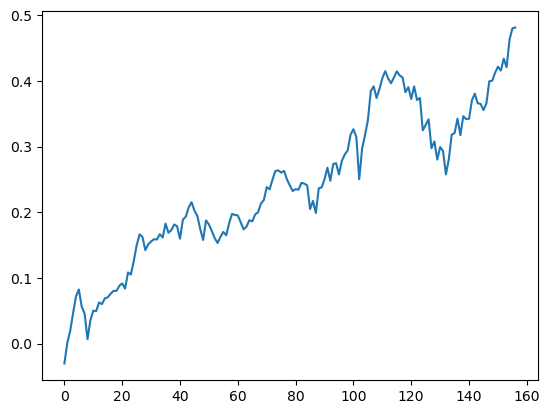

In [37]:
strategy_returns = []

for t in range(len(residuals)-1): 
    if residuals.iloc[t] <= 0:
        ret = 2 * proshares_df['HDG US Equity'].iloc[t+1] - basket_returns.iloc[t+1]
    else:
        ret = 2 * basket_returns.iloc[t+1] - proshares_df['HDG US Equity'].iloc[t+1]
    
    strategy_returns.append(ret)

pd.Series(strategy_returns).cumsum().plot()

In [38]:
portfolio_metrics_basic(pd.Series(strategy_returns).to_frame('Strategy'))

,Annnualized Return,Annnualized Vol,Annnualized SR
Strategy,0.036796,0.062243,0.591156


#### Q5 - not annualized (as not specified in question)

In [40]:
y = 'QAI US Equity' 
def get_params(data, y_col: str, x_col: list):
    columns = ['Alpha', 'R-Squared'] + x_col + ['Tracking Error']
    params_df = pd.DataFrame(index=columns)
    
    y = data[y_col]
    x = data[x_col]
    
    x = sm.add_constant(x) # added constant as learnt from LMFM HF series data replication and required in the qn
    model_alpha = sm.OLS(y, x).fit()
    r_squared_model_alpha = model_alpha.rsquared
    betas_model_alpha = model_alpha.params[1:]
    alpha_model_alpha = model_alpha.params[0] 
    std_error = np.std(residuals, ddof=1)
    information_ratio = (alpha_model_alpha/std_error) 
    
    tracking_error_alpha = (model_alpha.resid).std()
    print("Tracking Error ", tracking_error_alpha)
    
    parameters = [alpha_model_alpha] + [r_squared_model_alpha] + list(betas_model_alpha) + [tracking_error_alpha]
    params_df['With Intercept'] = parameters

    return params_df, alpha_model_alpha, information_ratio, r_squared_model_alpha

factors = list(proshares_df.columns)
factors.remove(y)
print(factors)
params_df, alpha_model_alpha, information_ratio, r_squared_model_alpha = get_params(proshares_df, y, factors)
params_df.loc[factors].rename(columns = {'With Intercept': 'Beta Values'})

['HDG US Equity', 'SPY US Equity', 'EEM US Equity', 'EFA US Equity', 'EUO US Equity', 'IWM US Equity', 'SPXU US Equity', 'UPRO US Equity']
Tracking Error  0.005738567328601326


,Beta Values
HDG US Equity,0.231451
SPY US Equity,0.565072
EEM US Equity,0.047792
EFA US Equity,0.032642
EUO US Equity,-0.020484
IWM US Equity,-0.000157
SPXU US Equity,0.051074
UPRO US Equity,-0.095099


In [41]:
print("These are not annualized:")
print("--------------------------")
print(f"Alpha of the model (α): {alpha_model_alpha:.4f}")
print(f"Information Ratio: {information_ratio:.4f}")
print(f"R-squared of the model (R²): {r_squared_model_alpha:.4f}")


These are not annualized:
--------------------------
Alpha of the model (α): -0.0005
Information Ratio: -0.0792
R-squared of the model (R²): 0.8420


MIN Correlation pair is ('SPXU US Equity', 'SPY US Equity'), with a correlation of -0.9555450332700004
MAX Correlation pair is ('UPRO US Equity', 'SPY US Equity'), with a correlation of 0.9964750451849607


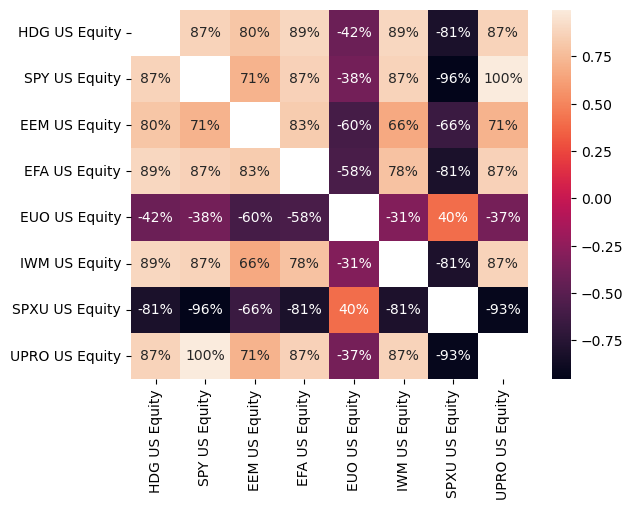

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr(data: pd.DataFrame):
    corr_mtx = data.corr() 
    corr_mtx[corr_mtx==1] = None
    sns.heatmap(corr_mtx,annot=True,fmt='.0%');

    corr_rank = corr_mtx.unstack().sort_values().dropna()
    pair_max = corr_rank.index[-1]
    pair_min = corr_rank.index[0]

    min_corr_value = corr_rank.iloc[0]
    max_corr_value = corr_rank.iloc[-1]
    
    print(f'MIN Correlation pair is {pair_min}, with a correlation of {min_corr_value}')
    print(f'MAX Correlation pair is {pair_max}, with a correlation of {max_corr_value}')
    
plot_corr(proshares_df[factors])

#### Q6

- The R-Squared is 0.842 meaning that 84.20\% of the variability in QAI's returns is explained by the replication, which suggests that this is quite accurate, though there is still some room for improvement. 
- The Information ratio is -0.0793, which is negative. This implies that the replication has not been able to generate excess returns relative to the risks (betas taken from the factors). Therefore, the replication might not be fully efficient in capturing the returns of the original strategy and in fact, taking on too much risks (potentially from the over diversification)
- A small negative alpha of -0.0005 indicates that the underperformance of the replication relative to QAI is minimal. Therefore, this suggests a relatively strong replication performance. 
- As for the betas, there is a diversified exposure across the various assets involved. SPY has a beta of 0.565 which is intuitive given that it follows the broad equity market exposure. On the other hand, EEM, EFA and EUO have lower weights which is obvious given that they represent emerging markets, international equities and currencies. Lastly, for UPRO and SPXU, the betas are minimal.
- Regarding the correlations, we do see that the factors are highly correlated with some even sharing 99.6%. This definitely inhibits the effectiveness of this model as multicollinearity is present. For instance, URPO is simply a leveraged version of SPY and thus they share a strong correlation. Therefore, this replication can be said to be questionable as the factors selected violate the assumptions of a linear regression.

# Q4

In [46]:
excel_file = pd.ExcelFile("./midterm_1_data.xlsx")
sheet_names = excel_file.sheet_names
sheet_names

['stocks excess returns', 'proshares excess returns', 'fx carry returns']

In [47]:
annualization_factor = 252 # 1 year for this part of the case since its daily data

In [48]:
fx_df = pd.read_excel("./midterm_1_data.xlsx", sheet_name = 'fx carry returns')
fx_df = fx_df.set_index('date')
fx_df['Shifted_JPY'] = fx_df['JPY'].shift(1)
fx_df = fx_df[['JPY', 'Shifted_JPY']]
fx_df.head()

,JPY,Shifted_JPY
date,,
2019-01-07,-0.001843,NaN
2019-01-08,-0.000324,-0.001843
2019-01-09,0.005222,-0.000324
2019-01-10,-0.002486,0.005222
2019-01-11,-0.000865,-0.002486


#### Q1

In [50]:
var_quantile = 0.01 
fx_df['VaR_1%'] = fx_df['Shifted_JPY'].expanding(min_periods = 1).quantile(var_quantile)
fx_df['VaR_1%'].tail(1).values[0]

-0.017181767219970005

#### Q2

In [52]:
z_score = -2.33 
window = 233 

'''
Rolling volatility, no sample mean 
'''

# from mid terms 2023 -> chose the mean method (based on sample ans)
rol_vol_jpy = np.sqrt((fx_df['JPY']**2).rolling(window).mean().shift())
fx_df['Normal_VaR_1%_rolling_vol'] = z_score * rol_vol_jpy
fx_df['Normal_VaR_1%_rolling_vol'].dropna().tail(3).values

array([-0.01335037, -0.0133586 , -0.01363107])

In [53]:
def calc_ewma_volatility(excess_returns: pd.Series, theta , initial_vol) -> pd.Series:
    if initial_vol is None: 
        var_t0 = excess_returns.var() # assumed to be the overall variance 
    else:
        var_t0 = initial_vol ** 2  
    ewma_var = [var_t0]
    for i in range(len(excess_returns.index)):
        new_ewma_var = ewma_var[-1] * theta + (excess_returns.iloc[i] ** 2) * (1 - theta)
        ewma_var.append(new_ewma_var)
    ewma_var.pop(0) # Remove var_t0
    ewma_vol = [np.sqrt(v) for v in ewma_var]
    return pd.Series(ewma_vol, index=excess_returns.index)
    
ewma_vol = calc_ewma_volatility(fx_df['JPY'], 0.94, 0.005)
fx_df['Normal_VaR_1%_ewma_vol'] = z_score * ewma_vol
fx_df['Normal_VaR_1%_ewma_vol'].dropna().tail(3).values


array([-0.01742988, -0.02014006, -0.02156662])

#### Q4

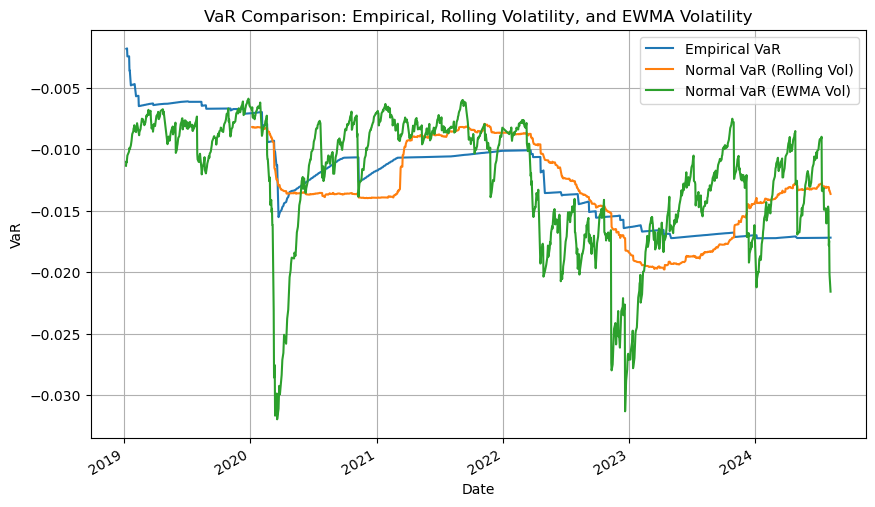

In [55]:
fx_df[['VaR_1%', 'Normal_VaR_1%_rolling_vol', 'Normal_VaR_1%_ewma_vol']].plot(figsize=(10, 6))

plt.title("VaR Comparison: Empirical, Rolling Volatility, and EWMA Volatility")
plt.xlabel("Date")
plt.ylabel("VaR")
plt.legend(["Empirical VaR", "Normal VaR (Rolling Vol)", "Normal VaR (EWMA Vol)"])
plt.grid(True)
plt.show()

#### Empirical VaR
Pros:
- Directly captures the real market conditions and is sensitive to any market events since its an expanding window of up to that point. Furthermore, this method does not follow a specific distribution, making it more flexible especially when normality does not hold.

Cons:
- However, this requires a large dataset especially since its at the 1% quantile for VaR to capture extreme events. Furthermore, this is unresponsive to recent volatility changes as all past data is treated equally regardless of market events. 


#### Normal VaR with Rolling Volatility (Normal_VaR_1%_rolling_vol)
Pros:
- Using rolling window estimates enable the calculation to be updated based on market conditions over the specified window of 233 days, smoothing out the volatility and reducing the short-term market noise. 

Cons:
- This assumes returns are normally distributed which does not hold true in financial markets since there may be extreme market events or fat tails. 
- It also assumes that all returns in the window are equally important and does not account for volatility clustering.
- Furthermore, the choice of the window size is critical and there needs to be a balance for short term vs long term trends. 

#### Normal VaR with EWMA Volatility (Normal_VaR_1%_ewma_vol)
Pros:
- EWMA assigns higher weights to more recent observations and can thus capture changes in volatility in the market. This makes it very responsive and thus captures volaility clustering which is common in FX markets. Furthermore, the exponential weighting reduces the impact of older returns and is more representative of current market conditions.

Cons: 
- This assumes returns are normally distributed which does not hold true in financial markets since there may be extreme market events or fat tails. This causes an underestimation of tail risk.
- The choice of lambda is important in balancing the recent vs past data. A lower lambda may make the estimate too volatile while a higher one will overtly smooth it and may cause it to underreact to changes. 


#### Q5

In [58]:
hit_ratio_rolling_vol = (fx_df['JPY'].loc[fx_df['Normal_VaR_1%_rolling_vol'].index] < fx_df['Normal_VaR_1%_rolling_vol']).mean()
hit_ratio_ewma_vol = (fx_df['JPY'].loc[fx_df['Normal_VaR_1%_ewma_vol'].index] < fx_df['Normal_VaR_1%_ewma_vol']).mean()
hit_ratio_empirical = (fx_df['JPY'].loc[fx_df['VaR_1%'].index] < fx_df['VaR_1%']).mean()

print(f"Hit Ratio (Rolling Volatility VaR): {hit_ratio_rolling_vol:.4f}")
print(f"Hit Ratio (EWMA Volatility VaR): {hit_ratio_ewma_vol:.4f}")
print(f"Hit Ratio (Empirical VaR): {hit_ratio_empirical:.4f}")



Hit Ratio (Rolling Volatility VaR): 0.0207
Hit Ratio (EWMA Volatility VaR): 0.0115
Hit Ratio (Empirical VaR): 0.0245


The EWMA Volatility VaR seems to perform best based on the hit ratios as it is closest to the 1% quantile. 